In [1]:
import itertools
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from IPython.display import HTML, Markdown, display

MEASUREMENTS_FOLDER = "Variance logs"

setting_names = set(
    [
        "texture size",
        "downscale",
        "number of clusters",
        "number of iterations",
        "random swap",
        "randomize empty clusters",
        "KHM",
        "staggered jitter",
        "jitter size",
        "video file",
    ]
)

def load_measurements(measurement_name: str):
    log_file_names = os.listdir(f"{MEASUREMENTS_FOLDER}/{measurement_name}")
    
    def setting_transform(value):
        match value:
            case "True":
                return "Yes"
            case "False":
                return "No"
        return value

    measurements = [
        {
            "settings" : {
                setting_name : setting_transform(setting_value)
                    for setting_name, setting_value in [
                            setting_text.split(':')
                                for setting_text in file_name.split('.')[0].split("|")
                        ]
            },
            "variance" : pd.read_csv(
                f"{MEASUREMENTS_FOLDER}/{measurement_name}/{file_name}"
            )["Variance"].tolist()[10:-10], # first and lust 10 frames removed
            "file name" : file_name
        }
        for file_name in log_file_names
    ]
    
    for measurement in measurements:
        assert (
            set(
                measurement["settings"].keys()
            ) == set(
                setting_names
            )
        )
    
    for measurement in measurements:
        measurement["total variance"] = sum(measurement["variance"]) / len(measurement["variance"])
    
    for measurement in measurements:
        measurement["peak variance"] = max(measurement["variance"])
    
    return measurements

def show_measurements_table(measurements):    
    def get_setting_value_lengths(measurements):
        return {
            setting_name : max(
                max(
                    [
                        len(measurement['settings'][setting_name])
                            for measurement in measurements
                    ]
                ),
                len(setting_name)
            )
            for setting_name in setting_names
        }
    
    def get_settings_same_everywhere(measurements):
        def is_setting_same_everywhere(setting_name):
            for measurement in measurements:
                if measurement["settings"][setting_name] != measurements[0]["settings"][setting_name]:
                    return False
            return True
        return [setting_name for setting_name in setting_names if is_setting_same_everywhere(setting_name)]
    
    setting_value_lengths = get_setting_value_lengths(measurements)
    settings_same_everywhere = get_settings_same_everywhere(measurements)
    
    def print_setting(name, value):
        print(value, end="")
        print(
            " " * (
                setting_value_lengths[name] - len(value)
            ),
            end=""
        )


    for setting_name in setting_names:
        if setting_name in settings_same_everywhere:
            continue
        print(setting_name, end="")
        print("  |  ", end="")
    print("variance")
    print("-" *
        (
            sum(
                [
                    setting_value_lengths[name] + 5
                    for name in setting_names
                    if not name in settings_same_everywhere
                ]
            ) + 8
        )
    )

    for measurement in measurements:
        for setting_name in setting_names:
            if setting_name in settings_same_everywhere:
                continue
            print_setting(setting_name, measurement['settings'][setting_name])
            print("  |  ", end="")
        total_variance_string = f"{measurement['total variance']:0.5f}"
        print(f'{total_variance_string:10}', end="")
        print()

In [2]:
def plot_diff(index1, index2):    
    diff = [
        a - b for a,b in zip(
            logs[index1]["variance"],
            logs[index2]["variance"]
        )
    ]
    
    _, ax = plt.subplots()
    
    sb.lineplot(
        x=logs[index1]["Frame"],
        y=diff,
        ax=ax,
        label=f"{names[index1]} -\n{names[index2]}"
    )    
    plt.ylabel("ΔVariance")
    
    plt.show() # display plots RIGHT NOW
    
def plot_log(indices, do_plot_diff = False):    
    _, ax = plt.subplots()
    
    for logIndex in indices:
        sb.lineplot(
            x=logs[logIndex]["Frame"],
            y=logs[logIndex]["variance"],
            ax=ax,
            label=names[logIndex]
        )
    
    if do_plot_diff:
        assert(len(indices) == 2)
        plot_diff(indices[0], indices[1])
    
    plt.show() # display plots RIGHT NOW

In [3]:
def init_seaborn():
    sb.set(
        font_scale=1.2,
        rc={
            "figure.figsize":(14, 6)
        },
        palette="deep"
    )

init_seaborn()

In [4]:
display(Markdown("# Old measurements (left as code example)"))

# Old measurements (left as code example)

In [5]:
display(Markdown("## Dataser 1: iterations vs clusters"))

M1 = load_measurements("old/1. iterations vs clusters")

M1 = sorted(
    M1,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        int(measurement["settings"]["number of clusters"]),
        int(measurement["settings"]["number of iterations"]),
    )
)


show_measurements_table(M1)

## Dataser 1: iterations vs clusters

video file  |  number of iterations  |  variance
------------------------------------------------
1           |  1                     |  0.01556   
1           |  2                     |  0.01546   
1           |  3                     |  0.01545   
1           |  4                     |  0.01546   
1           |  5                     |  0.01525   
1           |  6                     |  0.01525   
2           |  1                     |  0.00437   
2           |  2                     |  0.00433   
2           |  3                     |  0.00430   
2           |  4                     |  0.00426   
2           |  5                     |  0.00425   
2           |  6                     |  0.00424   
2           |  7                     |  0.00423   
2           |  8                     |  0.00423   
2           |  9                     |  0.00422   
2           |  10                    |  0.00421   
2           |  11                    |  0.00421   
2           |  12                  

### K-Means iterations vs clusters


#### Knecht et al. stoppind condition

* stop if variance = $10^{-4}$
* if did not converge after 20 iterations => new random initialization
* force random initialization every $5$th frame to avoid local minimum
        

#### Video 1

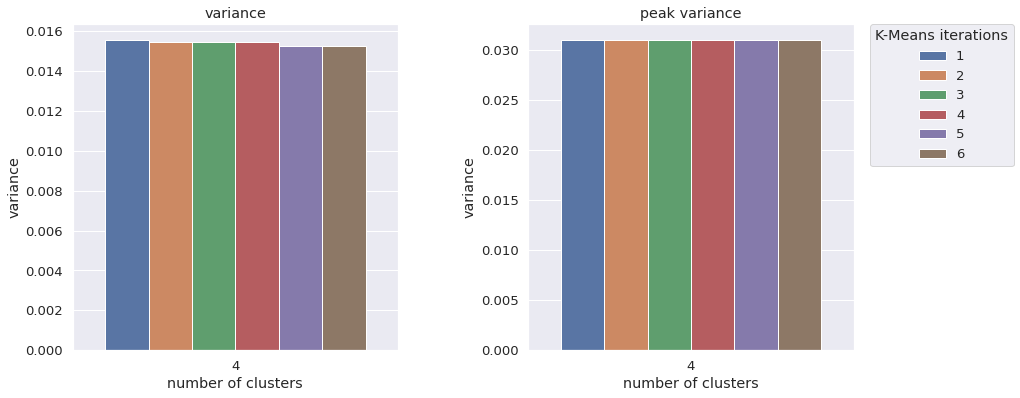

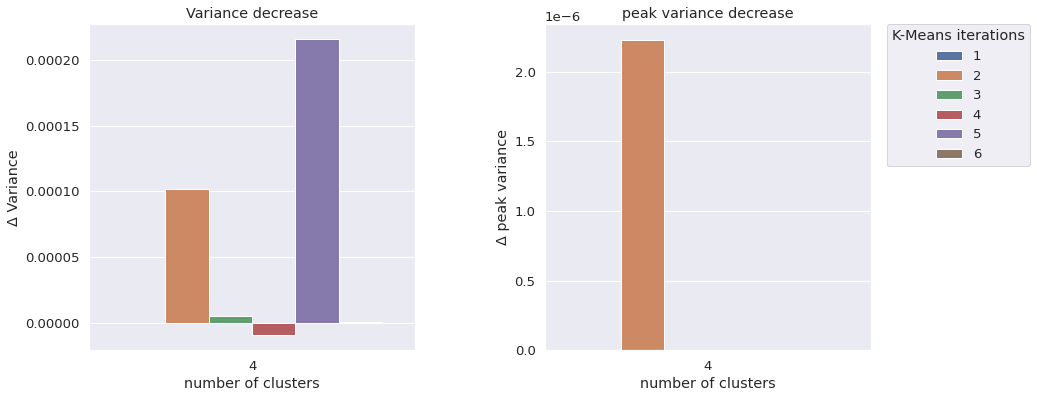

#### Video 2

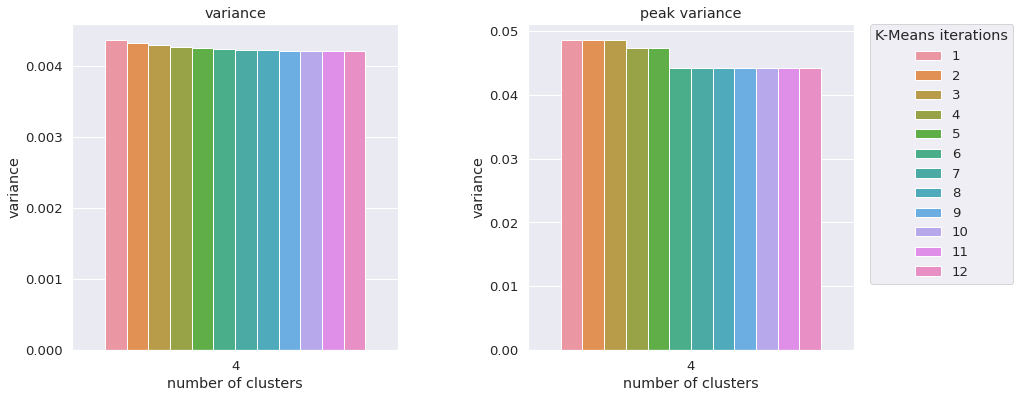

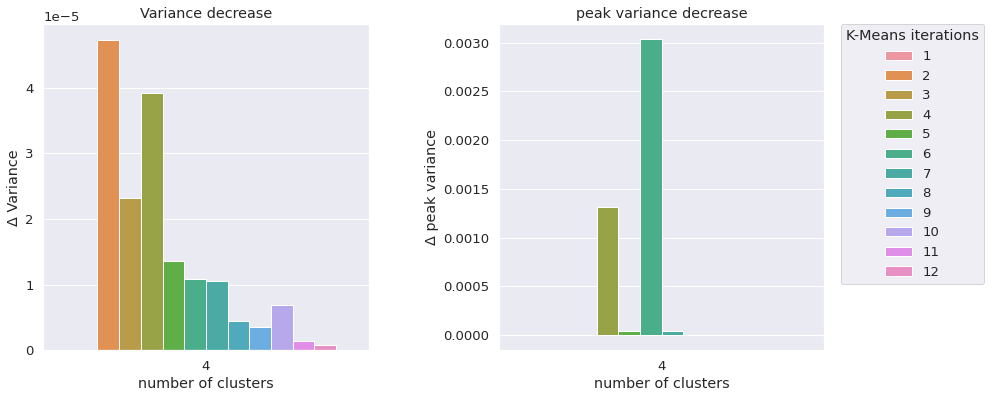

In [6]:
display(Markdown("### K-Means iterations vs clusters"))

display(
    Markdown(
        """
#### Knecht et al. stoppind condition

* stop if variance = $10^{-4}$
* if did not converge after 20 iterations => new random initialization
* force random initialization every $5$th frame to avoid local minimum
        """
    )
)

def jitter_plots():

    max_texture_size = 16
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    measurement['total variance'],
                    measurement['peak variance'],
                    int(measurement['settings']['number of iterations']),
                    int(measurement['settings']['number of clusters'])
                )
                    for measurement in M1
                        if measurement['settings']["video file"] == video_name
            ],
            columns=["total variance", "peak variance", "iterations", "clusters"]
        )



    total_variance_by_texture_size_with_jitter = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }
    
    for video in total_variance_by_texture_size_with_jitter:
        for i in range(1, len(total_variance_by_texture_size_with_jitter[video]["total variance"])):
            total_variance_by_texture_size_with_jitter[video].loc[i, "total variance decrease"] = (
                total_variance_by_texture_size_with_jitter[video].loc[i-1, "total variance"] -
                total_variance_by_texture_size_with_jitter[video].loc[i, "total variance"]
            )
            
    for video in total_variance_by_texture_size_with_jitter:
        for i in range(1, len(total_variance_by_texture_size_with_jitter[video]["peak variance"])):
            total_variance_by_texture_size_with_jitter[video].loc[i, "peak variance decrease"] = (
                total_variance_by_texture_size_with_jitter[video].loc[i-1, "peak variance"] -
                total_variance_by_texture_size_with_jitter[video].loc[i, "peak variance"]
            )
    
    def plot_video(video):
    
        display(Markdown(f"#### Video {video}"))
            
        def plot_absolute_decrease():

            _, axes = plt.subplots(1, 2)

            g = sb.barplot(
                data=total_variance_by_texture_size_with_jitter[f"video {video}"],
                x="clusters",
                y="total variance decrease",
                hue="iterations",
                ci=None,
                ax = axes[0],
            )

            g.legend().remove()

            axes[0].set_ylabel("Δ Variance")
            axes[0].set_xlabel("number of clusters")
            axes[0].set_title("Variance decrease")

            g = sb.barplot(
                data=total_variance_by_texture_size_with_jitter[f"video {video}"],
                x="clusters",
                y="peak variance decrease",
                hue="iterations",
                ci=None,
                ax = axes[1],
            )

            g.legend(
                bbox_to_anchor=(1.05, 1),
                loc='upper left',
                borderaxespad=0,
                title="K-Means iterations"
            )

            axes[1].set_ylabel("Δ peak variance")
            axes[1].set_xlabel("number of clusters")
            axes[1].set_title("peak variance decrease")

            plt.subplots_adjust(
                wspace=0.4,
            )

            plt.show()
            
        def plot_absolute_values():
            
            _, axes = plt.subplots(1, 2)

            g = sb.barplot(
                data=total_variance_by_texture_size_with_jitter[f"video {video}"],
                x="clusters",
                y="total variance",
                hue="iterations",
                ci=None,
                ax = axes[0],
            )

            g.legend().remove()

            axes[0].set_ylabel("variance")
            axes[0].set_xlabel("number of clusters")
            axes[0].set_title("variance")

            g = sb.barplot(
                data=total_variance_by_texture_size_with_jitter[f"video {video}"],
                x="clusters",
                y="peak variance",
                hue="iterations",
                ci=None,
                ax = axes[1],
            )

            g.legend(
                bbox_to_anchor=(1.05, 1),
                loc='upper left',
                borderaxespad=0,
                title="K-Means iterations"
            )

            axes[1].set_ylabel("variance")
            axes[1].set_xlabel("number of clusters")
            axes[1].set_title("peak variance")

            plt.subplots_adjust(
                wspace=0.4,
            )

            plt.show()        
            
        plot_absolute_values()
        plot_absolute_decrease()
        
    for video in ["1", "2"]:
        plot_video(video)

jitter_plots()

In [7]:
display(Markdown('## Dataset 2: subsample and jitter'))

M2 = load_measurements("old/2. subsample and jitter")

M2 = sorted(
    M2,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        int(measurement["settings"]["jitter size"]),
        measurement["settings"]["staggered jitter"],
    )
)


show_measurements_table(M2)

## Dataset 2: subsample and jitter

video file  |  staggered jitter  |  jitter size  |  texture size  |  variance
-----------------------------------------------------------------------------
1           |  No                |  1            |  1024          |  0.00631   
1           |  No                |  1            |  512           |  0.00631   
1           |  No                |  2            |  512           |  0.00631   
1           |  Yes               |  2            |  512           |  0.00631   
1           |  No                |  1            |  256           |  0.00631   
1           |  No                |  2            |  256           |  0.00631   
1           |  Yes               |  2            |  256           |  0.00631   
1           |  No                |  4            |  256           |  0.00631   
1           |  Yes               |  4            |  256           |  0.00631   
1           |  No                |  1            |  128           |  0.00620   
1           |  No                |  2       

### Subsampling

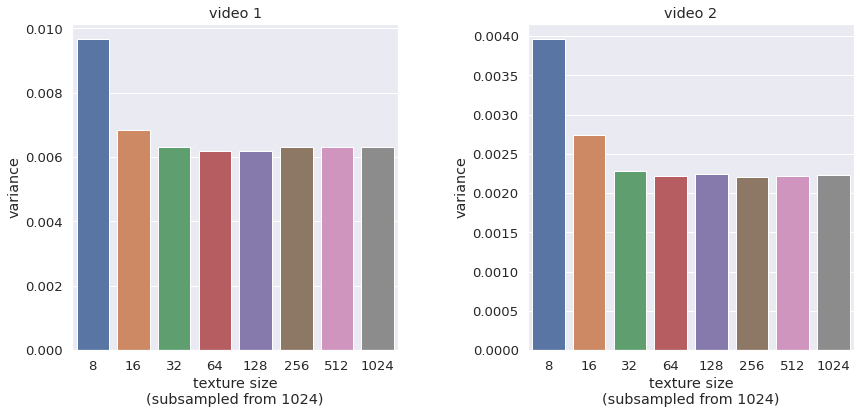

In [8]:
display(Markdown("### Subsampling"))

def subsample_plots():
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    int(measurement['settings']['texture size']),
                    measurement['total variance'],
                )
                    for measurement in M2
                        if measurement['settings']["video file"] == video_name
                        and measurement['settings']["jitter size"] == "1"
            ],
            columns=["texture size", "total variance"]
        )



    total_variance_by_texture_size = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }
    
    _, axes = plt.subplots(1, 2)

    sb.barplot(
        x=total_variance_by_texture_size["video 1"]["texture size"],
        y=total_variance_by_texture_size["video 1"]["total variance"],
        ax=axes[0],
        ci=None,
    )

    axes[0].set_ylabel("variance")
    axes[0].set_xlabel("texture size\n(subsampled from 1024)")
    axes[0].set_title("video 1")

    sb.barplot(
        x=total_variance_by_texture_size["video 2"]["texture size"],
        y=total_variance_by_texture_size["video 2"]["total variance"],
        ax=axes[1],
        ci=None,
    )

    axes[1].set_ylabel("variance")
    axes[1].set_xlabel("texture size\n(subsampled from 1024)")
    axes[1].set_title("video 2")

    plt.subplots_adjust(
        wspace=0.4,
    )

    plt.show()

subsample_plots()

### Jitter

#### No jitter VS staggered jitter

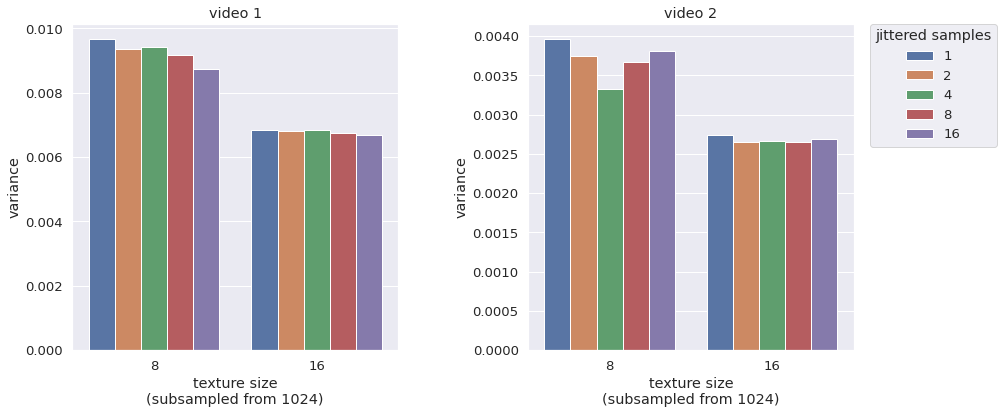

In [9]:
display(Markdown("### Jitter"))

display(Markdown("#### No jitter VS staggered jitter"))

def jitter_plots():

    max_texture_size = 16
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    int(measurement['settings']['texture size']),
                    measurement['total variance'],
                    int(measurement['settings']['jitter size'])
                )
                    for measurement in M2
                        if measurement['settings']["video file"] == video_name
                        and int(measurement['settings']["texture size"]) <= max_texture_size
                        and (
                            measurement['settings']["staggered jitter"] == "Yes"
                            or measurement['settings']["jitter size"] == "1"
                        )
            ],
            columns=["texture size", "total variance", "jitter size"]
        )



    total_variance_by_texture_size_with_jitter = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }

    _, axes = plt.subplots(1, 2)

    g = sb.barplot(
        data=total_variance_by_texture_size_with_jitter["video 1"],
        x="texture size",
        y="total variance",
        hue="jitter size",
        ci=None,
        ax = axes[0],
    )

    g.legend().remove()

    axes[0].set_ylabel("variance")
    axes[0].set_xlabel("texture size\n(subsampled from 1024)")
    axes[0].set_title("video 1")

    g = sb.barplot(
        data=total_variance_by_texture_size_with_jitter["video 2"],
        x="texture size",
        y="total variance",
        hue="jitter size",
        ci=None,
        ax = axes[1],
    )

    g.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0,
        title="jittered samples"
    )

    axes[1].set_ylabel("variance")
    axes[1].set_xlabel("texture size\n(subsampled from 1024)")
    axes[1].set_title("video 2")

    plt.subplots_adjust(
        wspace=0.4,
    )

    plt.show()

jitter_plots()

#### Staggered VS scanline jitter

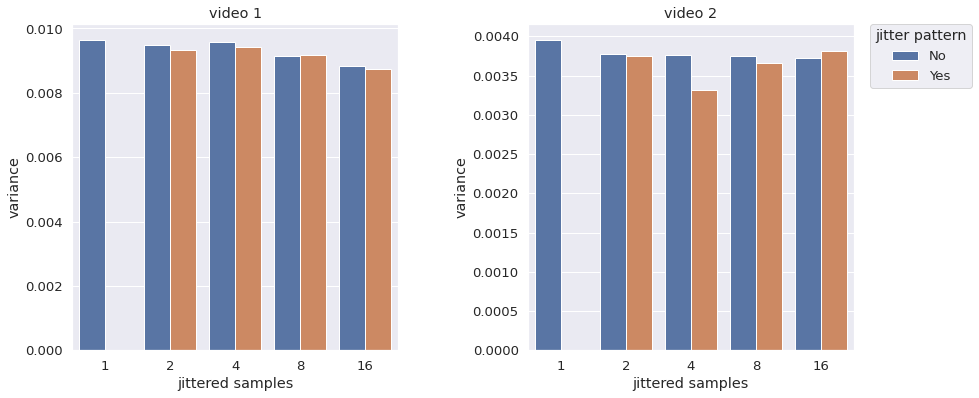

In [10]:
display(Markdown("#### Staggered VS scanline jitter"))


def jitter_staggered_vs_scanline_plots():

    texture_size = 8
    
    def load_video(video_name):
        return pd.DataFrame(
            list(
                [
                    (
                        measurement['total variance'],
                        measurement['settings']['jitter size'],
                        measurement['settings']['staggered jitter']                  
                    )
                    for measurement in M2
                        if measurement['settings']["video file"] == video_name
                        and int(measurement['settings']["texture size"]) == texture_size
                ]
            ),
            columns=["total variance", "jitter size", "staggered jitter"]
        )

    total_variance_by_texture_size_with_jitter = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }

    _, axes = plt.subplots(1, 2)

    g = sb.barplot(
        data=total_variance_by_texture_size_with_jitter["video 1"],
        x="jitter size",
        y="total variance",
        hue="staggered jitter",
        ci=None,
        ax = axes[0],
    )

    g.legend().remove()

    axes[0].set_ylabel("variance")
    axes[0].set_xlabel("jittered samples")
    axes[0].set_title("video 1")

    g = sb.barplot(
        data=total_variance_by_texture_size_with_jitter["video 2"],
        x="jitter size",
        y="total variance",
        hue="staggered jitter",
        ci=None,
        ax = axes[1],
    )

    g.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0,
        title="jitter pattern"
    )
    axes[1].set_ylabel("variance")
    axes[1].set_xlabel("jittered samples")
    axes[1].set_title("video 2")

    plt.subplots_adjust(
        wspace=0.4,
    )

    plt.show()

jitter_staggered_vs_scanline_plots()

In [11]:
display(Markdown('## Dataset 3: subsample vs downscale'))

M3 = load_measurements("old/3. subsample vs downscale")

M3 = sorted(
    M3,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        measurement["settings"]["downscale"],
    )
)

show_measurements_table(M2)

## Dataset 3: subsample vs downscale

video file  |  staggered jitter  |  jitter size  |  texture size  |  variance
-----------------------------------------------------------------------------
1           |  No                |  1            |  1024          |  0.00631   
1           |  No                |  1            |  512           |  0.00631   
1           |  No                |  2            |  512           |  0.00631   
1           |  Yes               |  2            |  512           |  0.00631   
1           |  No                |  1            |  256           |  0.00631   
1           |  No                |  2            |  256           |  0.00631   
1           |  Yes               |  2            |  256           |  0.00631   
1           |  No                |  4            |  256           |  0.00631   
1           |  Yes               |  4            |  256           |  0.00631   
1           |  No                |  1            |  128           |  0.00620   
1           |  No                |  2       

### Subsample VS downscale

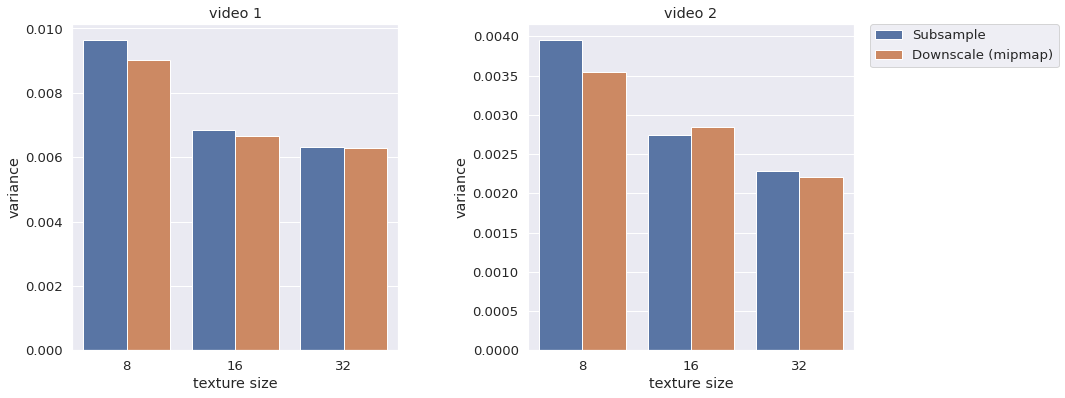

In [12]:
display(Markdown("### Subsample VS downscale"))

def subsample_vs_downscale_plots():

    max_texture_size = 32
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    measurement['total variance'],
                    int(measurement['settings']['texture size']),
                    
                    "Downscale (mipmap)"
                            if measurement['settings']['downscale'] == "Yes"
                    else "Subsample"     
                )
                    for measurement in M3
                        if measurement['settings']["video file"] == video_name
                        and int(measurement['settings']["texture size"]) <= max_texture_size
            ],
            columns=["total variance", "texture size", "downscale"]
        )

    total_variance_by_texture_size_with_jitter = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }

    _, axes = plt.subplots(1, 2)

    g = sb.barplot(
        data=total_variance_by_texture_size_with_jitter["video 1"],
        x="texture size",
        y="total variance",
        hue="downscale",
        ci=None,
        ax = axes[0],
    )

    g.legend().remove()

    axes[0].set_ylabel("variance")
    axes[0].set_xlabel("texture size")
    axes[0].set_title("video 1")

    g = sb.barplot(
        data=total_variance_by_texture_size_with_jitter["video 2"],
        x="texture size",
        y="total variance",
        hue="downscale",
        ci=None,
        ax = axes[1],
    )

    g.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0,
    )
    axes[1].set_ylabel("variance")
    axes[1].set_xlabel("texture size")
    axes[1].set_title("video 2")

    plt.subplots_adjust(
        wspace=0.4,
    )

    plt.show()

subsample_vs_downscale_plots()

In [13]:
display(Markdown("# ToDo measurements"))

display(
    Markdown(
"""
|Measurement|Clusters|Iterations|Texture size|
|----|----|----|----|
|subsampling|🗸|-|🗸|
|downscaling|-|-|🗸|
|jitter|-|-|🗸|
|scanline jitter|-|-|🗸|
|randomize vs freeze empty clusters|-|-|🗸|
|local mimimum check|🗸|-|-|

* Random swap
    * randomize 1 cluster
    * full randomization
    * simple K-Means
* KHM and random swap
    * KM
    * KHM
    * KM + random swap

----

In order to show, that KM does not get stuck in local minimum:

* 12 iterations of KM
* 6 iterations of random swap
* 12 iterations of KHM

**plot Variance and peak variance**

-----

Use random swap only as a reference to check for local minimum. KHM is clearly superior,
because it does not require additional dispatches and texture reads.

But do make performance benchmarks to show this, and show that KHM achieves similar quality to random swap.
"""
    )
)

# ToDo measurements


|Measurement|Clusters|Iterations|Texture size|
|----|----|----|----|
|subsampling|🗸|-|🗸|
|downscaling|-|-|🗸|
|jitter|-|-|🗸|
|scanline jitter|-|-|🗸|
|randomize vs freeze empty clusters|-|-|🗸|
|local mimimum check|🗸|-|-|

* Random swap
    * randomize 1 cluster
    * full randomization
    * simple K-Means
* KHM and random swap
    * KM
    * KHM
    * KM + random swap

----

In order to show, that KM does not get stuck in local minimum:

* 12 iterations of KM
* 6 iterations of random swap
* 12 iterations of KHM

**plot Variance and peak variance**

-----

Use random swap only as a reference to check for local minimum. KHM is clearly superior,
because it does not require additional dispatches and texture reads.

But do make performance benchmarks to show this, and show that KHM achieves similar quality to random swap.


In [14]:
display(Markdown('# New measurements'))

# New measurements

In [15]:
display(Markdown('## Dataset 1: subsampling'))

M1 = load_measurements("1. subsampling")

M2 = sorted(
    M2,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
    )
)


show_measurements_table(M1)

## Dataset 1: subsampling

video file  |  number of clusters  |  texture size  |  variance
---------------------------------------------------------------
1           |  4                   |  8             |  0.01724   
1           |  6                   |  8             |  0.01019   
1           |  8                   |  8             |  0.00679   
1           |  12                  |  8             |  0.00373   
1           |  16                  |  8             |  0.00247   
1           |  4                   |  16            |  0.01499   
1           |  6                   |  16            |  0.00827   
1           |  8                   |  16            |  0.00536   
1           |  12                  |  16            |  0.00281   
1           |  16                  |  16            |  0.00183   
1           |  4                   |  32            |  0.01454   
1           |  6                   |  32            |  0.00772   
1           |  8                   |  32            |  0.00503   
1           | 

### Plots

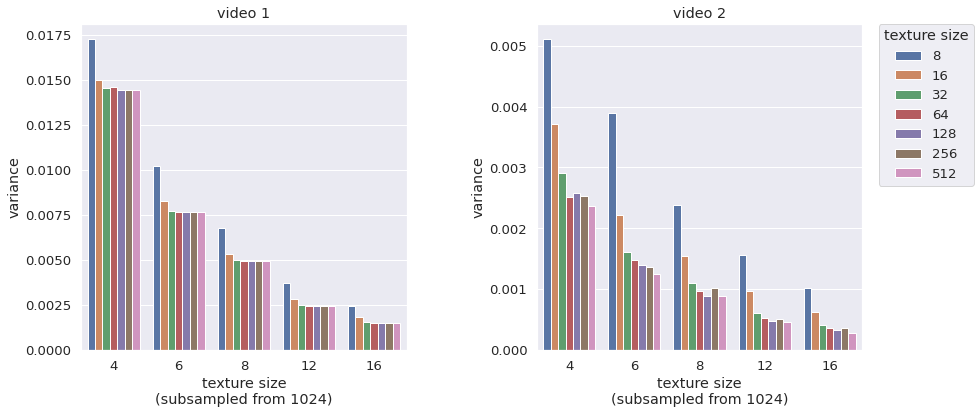

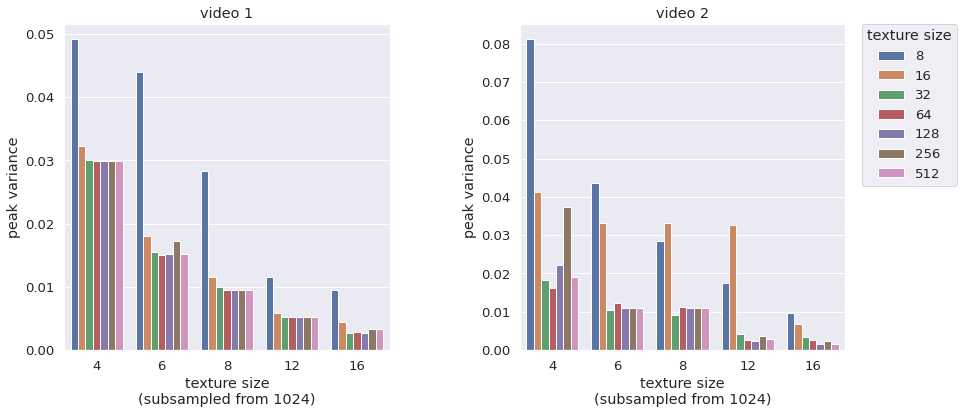

In [16]:
display(Markdown("### Plots"))

def subsample_variance_plots():
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    int(measurement['settings']['texture size']),
                    measurement['total variance'],
                    measurement['settings']['number of clusters'],
                )
                    for measurement in M1
                        if measurement['settings']["video file"] == video_name
            ],
            columns=["texture size", "total variance", "number of clusters"]
        )



    total_variance_by_texture_size = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }
    
    _, axes = plt.subplots(1, 2)

    g = sb.barplot(
        x=total_variance_by_texture_size["video 1"]["number of clusters"],
        y=total_variance_by_texture_size["video 1"]["total variance"],
        ax=axes[0],
        hue=total_variance_by_texture_size["video 1"]["texture size"],
        ci=None,
    )
    
    g.legend().remove()

    axes[0].set_ylabel("variance")
    axes[0].set_xlabel("texture size\n(subsampled from 1024)")
    axes[0].set_title("video 1")

    g = sb.barplot(
        x=total_variance_by_texture_size["video 2"]["number of clusters"],
        y=total_variance_by_texture_size["video 2"]["total variance"],
        ax=axes[1],
        hue=total_variance_by_texture_size["video 2"]["texture size"],
        ci=None,
    )

    axes[1].set_ylabel("variance")
    axes[1].set_xlabel("texture size\n(subsampled from 1024)")
    axes[1].set_title("video 2")
    
    g.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0,
        title="texture size"
    )

    plt.subplots_adjust(
        wspace=0.4,
    )

    plt.show()
    
def subsample_peak_variance_plots():
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    int(measurement['settings']['texture size']),
                    measurement['total variance'],
                    measurement['peak variance'],
                    measurement['settings']['number of clusters'],
                )
                    for measurement in M1
                        if measurement['settings']["video file"] == video_name
            ],
            columns=["texture size", "total variance", "peak variance", "number of clusters"]
        )



    total_variance_by_texture_size = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }
    
    _, axes = plt.subplots(1, 2)

    g = sb.barplot(
        x=total_variance_by_texture_size["video 1"]["number of clusters"],
        y=total_variance_by_texture_size["video 1"]["peak variance"],
        ax=axes[0],
        hue=total_variance_by_texture_size["video 1"]["texture size"],
        ci=None,
    )
    
    g.legend().remove()

    axes[0].set_ylabel("peak variance")
    axes[0].set_xlabel("texture size\n(subsampled from 1024)")
    axes[0].set_title("video 1")

    g = sb.barplot(
        x=total_variance_by_texture_size["video 2"]["number of clusters"],
        y=total_variance_by_texture_size["video 2"]["peak variance"],
        ax=axes[1],
        hue=total_variance_by_texture_size["video 2"]["texture size"],
        ci=None,
    )

    axes[1].set_ylabel("peak variance")
    axes[1].set_xlabel("texture size\n(subsampled from 1024)")
    axes[1].set_title("video 2")
    
    g.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        borderaxespad=0,
        title="texture size"
    )

    plt.subplots_adjust(
        wspace=0.4,
    )

    plt.show()
    
subsample_variance_plots()
subsample_peak_variance_plots()

In [17]:
display(Markdown('## Dataset 2: scaling vs subsampling'))

M2 = load_measurements("2. scaling vs subsampling")

M2 = sorted(
    M2,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        measurement["settings"]["downscale"],
    )
)


show_measurements_table(M2)

## Dataset 2: scaling vs subsampling

video file  |  downscale  |  texture size  |  variance
------------------------------------------------------
1           |  No         |  512           |  0.00765   
1           |  Yes        |  512           |  0.00765   
1           |  No         |  256           |  0.00766   
1           |  Yes        |  256           |  0.00773   
1           |  No         |  128           |  0.00765   
1           |  Yes        |  128           |  0.00765   
1           |  No         |  64            |  0.00764   
1           |  Yes        |  64            |  0.00766   
1           |  No         |  32            |  0.00772   
1           |  Yes        |  32            |  0.00783   
1           |  No         |  16            |  0.00827   
1           |  Yes        |  16            |  0.00809   
1           |  No         |  8             |  0.01019   
1           |  Yes        |  8             |  0.00966   
2           |  No         |  512           |  0.00125   
2           |  Yes        |  512   

### Plots

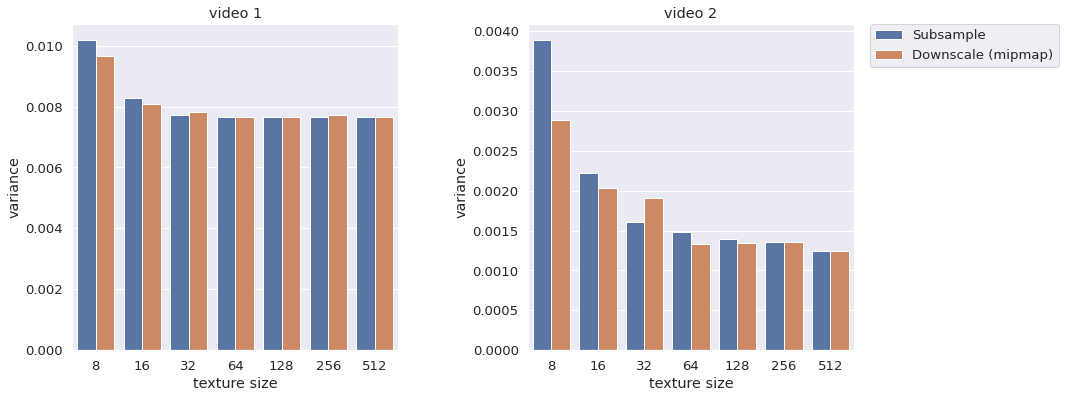

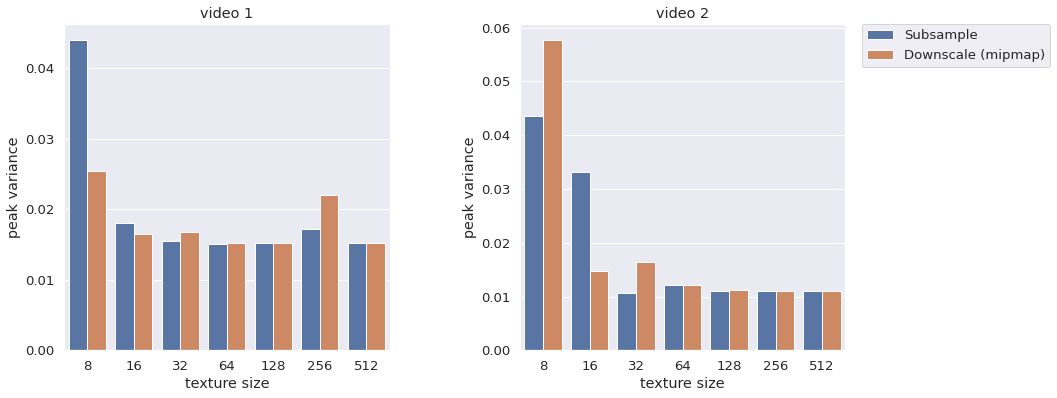

In [18]:
display(Markdown("### Plots"))

def subsample_vs_downscale_plots():
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    measurement['total variance'],
                    measurement['peak variance'],
                    int(measurement['settings']['texture size']),
                    
                    "Downscale (mipmap)"
                            if measurement['settings']['downscale'] == "Yes"
                    else "Subsample"     
                )
                    for measurement in M2
                        if measurement['settings']["video file"] == video_name
            ],
            columns=["total variance", "peak variance", "texture size", "downscale"]
        )

    total_variance_by_texture_size_with_jitter = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }

    def plot_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=total_variance_by_texture_size_with_jitter["video 1"],
            x="texture size",
            y="total variance",
            hue="downscale",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("texture size")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=total_variance_by_texture_size_with_jitter["video 2"],
            x="texture size",
            y="total variance",
            hue="downscale",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
        )
        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("texture size")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def plot_peak_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=total_variance_by_texture_size_with_jitter["video 1"],
            x="texture size",
            y="peak variance",
            hue="downscale",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("texture size")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=total_variance_by_texture_size_with_jitter["video 2"],
            x="texture size",
            y="peak variance",
            hue="downscale",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
        )
        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("texture size")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    plot_variance()
    plot_peak_variance()

subsample_vs_downscale_plots()

In [19]:
display(Markdown('## Jitter'))

## Jitter

In [20]:
display(Markdown('### Dataset 3: staggered jitter'))

M3 = load_measurements("3. staggered jitter")

M3 = sorted(
    M3,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        measurement["settings"]["jitter size"],
    )
)


show_measurements_table(M3)

### Dataset 3: staggered jitter

video file  |  jitter size  |  texture size  |  variance
--------------------------------------------------------
1           |  1            |  64            |  0.00764   
1           |  1            |  32            |  0.00772   
1           |  2            |  32            |  0.00774   
1           |  1            |  16            |  0.00827   
1           |  2            |  16            |  0.00832   
1           |  4            |  16            |  0.00812   
1           |  1            |  8             |  0.01019   
1           |  2            |  8             |  0.01012   
1           |  4            |  8             |  0.00982   
1           |  8            |  8             |  0.00970   
1           |  1            |  4             |  0.01538   
1           |  16           |  4             |  0.01450   
1           |  2            |  4             |  0.01513   
1           |  4            |  4             |  0.01496   
1           |  8            |  4             |  0.01500   
2

In [21]:
display(Markdown('### Dataset 4: scanline jitter'))

M4 = load_measurements("4. scanline jitter")

M4 = sorted(
    M4,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        measurement["settings"]["jitter size"],
    )
)

show_measurements_table(M4)



### Dataset 4: scanline jitter

video file  |  jitter size  |  texture size  |  variance
--------------------------------------------------------
1           |  1            |  64            |  0.00764   
1           |  1            |  32            |  0.00772   
1           |  2            |  32            |  0.00772   
1           |  1            |  16            |  0.00827   
1           |  2            |  16            |  0.00814   
1           |  4            |  16            |  0.00815   
1           |  1            |  8             |  0.01019   
1           |  2            |  8             |  0.01004   
1           |  4            |  8             |  0.00994   
1           |  8            |  8             |  0.01005   
1           |  1            |  4             |  0.01538   
1           |  16           |  4             |  0.01518   
1           |  2            |  4             |  0.01507   
1           |  4            |  4             |  0.01554   
1           |  8            |  4             |  0.01532   
2

#### Plots

##### Staggered jitter

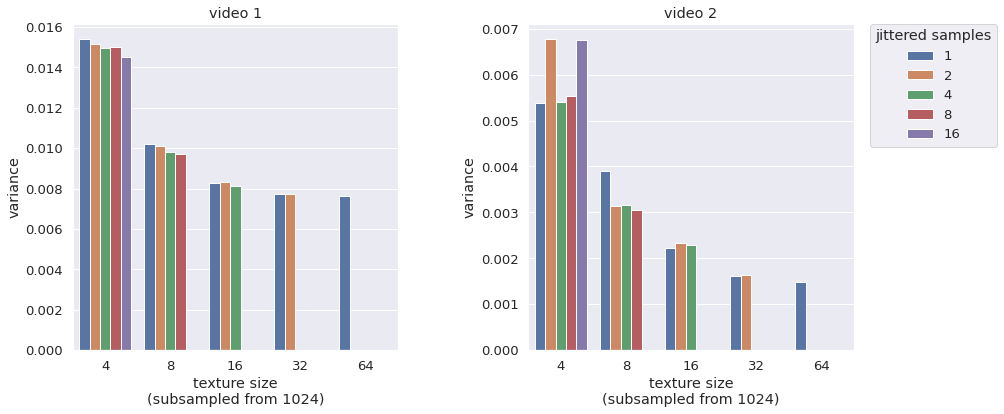

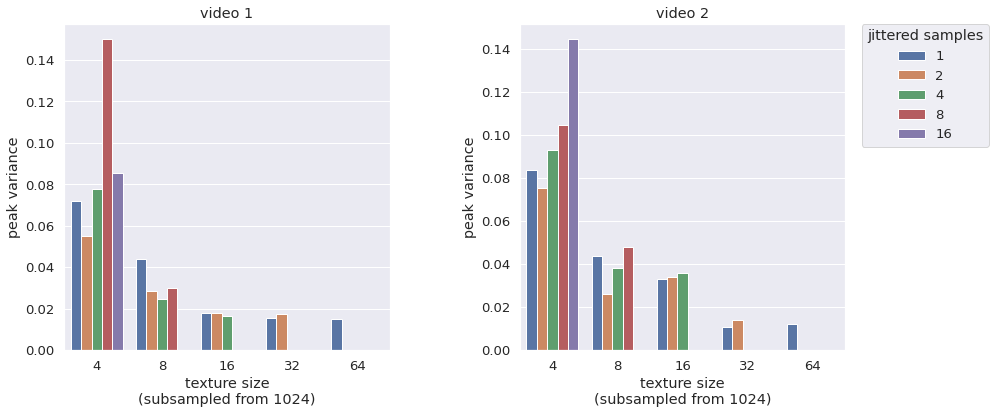

##### Scanline jitter

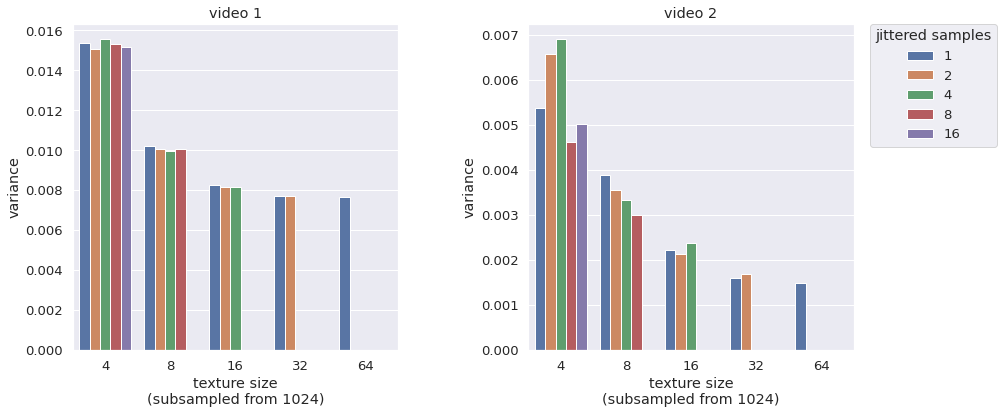

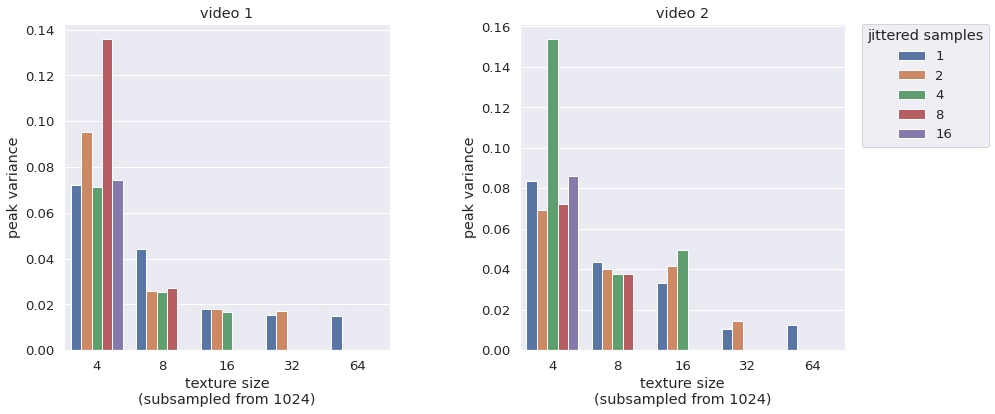

##### Difference

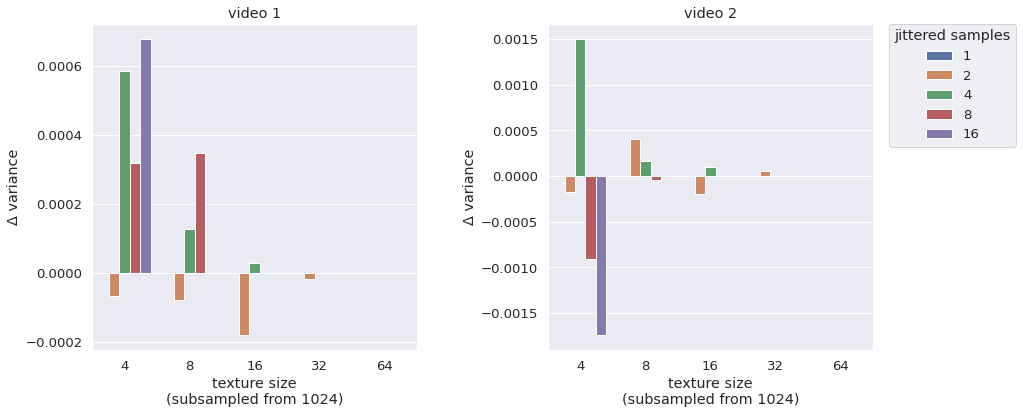

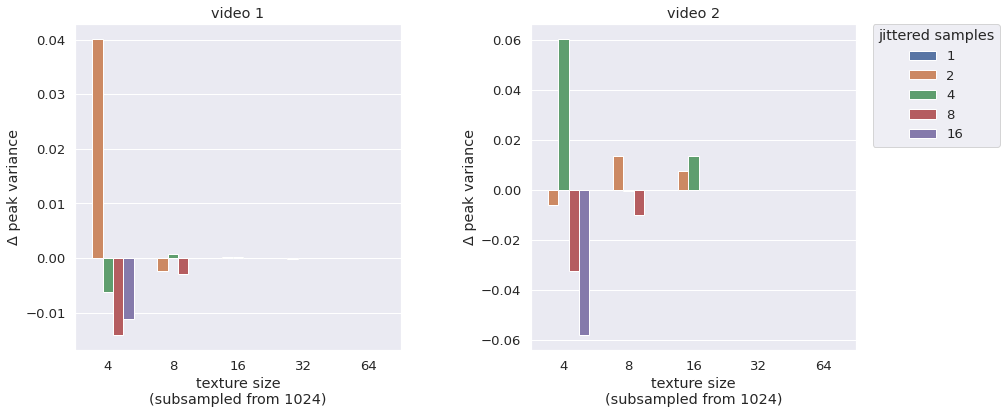


Positive numbers mean variance is greater with scanline jitter.
            

In [22]:
display(Markdown("#### Plots"))

def jitter_plots():
    
    def load_video(video_name, measurements):
        return pd.DataFrame(
            [
                (
                    int(measurement['settings']['texture size']),
                    measurement['total variance'],
                    measurement['peak variance'],
                    int(measurement['settings']['jitter size'])
                )
                    for measurement in measurements
                        if measurement['settings']["video file"] == video_name
            ],
            columns=["texture size", "total variance", "peak variance", "jitter size"]
        )
    
    def load_video_delta(video_name):
        return pd.DataFrame(
            [
                (
                    int(M4[i]['settings']['texture size']),
                    M4[i]['total variance'] - M3[i]['total variance'],
                    M4[i]['peak variance'] - M3[i]['peak variance'],
                    int(M4[i]['settings']['jitter size'])
                )
                    for i in range(len(M4))
                        if M4[i]['settings']["video file"] == video_name
            ],
            columns=["texture size", "delta variance", "delta peak variance", "jitter size"]
        )


    variance_by_texture_size_with_staggered_jitter = {
        f"video {video}" : load_video(video, M3)
            for video in ["1", "2"]
    }
    
    variance_by_texture_size_with_scanline_jitter = {
        f"video {video}" : load_video(video, M4)
            for video in ["1", "2"]
    }
    
    delta_variance_by_texture_size_with_different_jitter = {
        f"video {video}" : load_video_delta(video)
            for video in ["1", "2"]
    }

    display(Markdown("##### Staggered jitter"))
    
    def plot_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=variance_by_texture_size_with_staggered_jitter["video 1"],
            x="texture size",
            y="total variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=variance_by_texture_size_with_staggered_jitter["video 2"],
            x="texture size",
            y="total variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def plot_peak_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=variance_by_texture_size_with_staggered_jitter["video 1"],
            x="texture size",
            y="peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=variance_by_texture_size_with_staggered_jitter["video 2"],
            x="texture size",
            y="peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
        
    plot_variance()
    plot_peak_variance()    
    
    display(Markdown("##### Scanline jitter"))
    
    def plot_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=variance_by_texture_size_with_scanline_jitter["video 1"],
            x="texture size",
            y="total variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=variance_by_texture_size_with_scanline_jitter["video 2"],
            x="texture size",
            y="total variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def plot_peak_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=variance_by_texture_size_with_scanline_jitter["video 1"],
            x="texture size",
            y="peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=variance_by_texture_size_with_scanline_jitter["video 2"],
            x="texture size",
            y="peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
        
    plot_variance()
    plot_peak_variance()
    
    display(Markdown("##### Difference"))
    
    def plot_delta_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=delta_variance_by_texture_size_with_different_jitter["video 1"],
            x="texture size",
            y="delta variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("Δ variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=delta_variance_by_texture_size_with_different_jitter["video 2"],
            x="texture size",
            y="delta variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("Δ variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def plot_delta_peak_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=delta_variance_by_texture_size_with_different_jitter["video 1"],
            x="texture size",
            y="delta peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("Δ peak variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=delta_variance_by_texture_size_with_different_jitter["video 2"],
            x="texture size",
            y="delta peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("Δ peak variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
        
    plot_delta_variance()
    plot_delta_peak_variance()
    
    display(
        Markdown(
            """
Positive numbers mean variance is greater with scanline jitter.
            """
        )
    )

jitter_plots()

display(
    Markdown(
        """

        """
    )
)